In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Loading

In [5]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [6]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state.pth.tar', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=22, out_features=10, bias=True)
        (1): Tanh()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=22, out_features=10, bias=True)
        (1): Tanh()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=22, out_features=10, bias=True)
        (1): Tanh()
        (2): Linear(in_features=10, out_features=20, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=10, out_features=10, bias=True)
          (1): Tanh()
          (2): Linear(in_features=10, out_features=10, bias=True)
          (3): Tanh()
          (4): Linear(in_fea

In [9]:
loader = torch.load('gaia_train.pt')

## Inference

In [41]:
def sample(z, t):
    sol_y = model.diffeq_solver.sample_traj_from_prior(z, t, n_traj_samples = 1)
    out = model.decoder(sol_y)
    return out

In [86]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
samples = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    true = batch['data_to_predict']
    truths.extend([x for x in true])
    mask = batch['observed_mask']
    mask_pred = batch['mask_predicted_data']
#     mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp']
    truth_time_steps = t[mask.nonzero()]
    ts.append(t.detach().cpu())
    z_u, z_std = model.encoder_z0.forward(x, t)
#     rec = model.get_reconstruction(time_steps_to_predict=t, truth=x, truth_time_steps=t)
#     recs.append(rec[0].detach().cpu())
#     z_u = z_u.squeeze()
    s = sample(z_u, t)[0]
    samples.extend([x for x in s])
    z_u = z_u.detach().cpu()
    z_std = z_std.detach().cpu()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


In [88]:
len(samples), len(truths)

(142, 142)

In [92]:
samples[10]

tensor([[ 1.4607e-02],
        [ 1.5565e-02],
        [ 1.7724e-02],
        [ 1.8444e-02],
        [ 1.8541e-02],
        [ 2.0004e-02],
        [ 2.0562e-02],
        [ 2.1485e-02],
        [ 2.1796e-02],
        [ 2.2205e-02],
        [ 2.2280e-02],
        [ 2.2199e-02],
        [ 2.2050e-02],
        [ 2.1506e-02],
        [ 2.1148e-02],
        [ 2.0168e-02],
        [ 1.9608e-02],
        [ 1.8209e-02],
        [ 1.7457e-02],
        [ 1.5654e-02],
        [ 1.4716e-02],
        [ 1.2526e-02],
        [ 1.1411e-02],
        [ 8.8501e-03],
        [ 7.5643e-03],
        [ 4.6478e-03],
        [ 3.1987e-03],
        [-5.8020e-05],
        [-1.6632e-03],
        [-5.2451e-03],
        [-6.9994e-03],
        [-1.0892e-02],
        [-1.2788e-02],
        [-1.6977e-02],
        [-1.9009e-02],
        [-2.3479e-02],
        [-2.5640e-02],
        [-3.0378e-02],
        [-3.2661e-02],
        [-3.7654e-02],
        [-4.0053e-02],
        [-4.5287e-02],
        [-4.7796e-02],
        [-5

In [93]:
truths[10]

tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-1.0217],
        [ 0.0000],
        [-0.4908],
        [ 0.0000],
        [ 1.7857],
        [ 0.3068],
        [-0.8754],
        [ 0.8261],
        [-0.6027],
        [ 0.5211],
        [ 0.3854],
        [-0.9254],
        [ 0.1931],
        [ 0.4761],
        [-0.9574],
        [ 0.0000],
        [ 0.2265],
        [ 3.0548],
        [-0.7341],
        [ 0.6747],
        [-0.4662],
        [-0.2592],
        [-0.6842],
        [-0.6582],
        [-0.7748],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])

In [67]:
z_us = torch.cat(z_us,1).squeeze()
z_stds = torch.cat(z_stds,1).squeeze()
# truths = torch.cat(truths,0).squeeze()

In [ ]:
recs = torch.cat(recs,1).squeeze()

In [ ]:
recs.shape

In [ ]:
z_us.shape, z_stds.shape, truths.shape

### Results

In [34]:
ix = 0

In [35]:
observed_data = batch['observed_data'][ix]
mask = batch['observed_mask'][ix]#.squeeze()
x = torch.cat((observed_data, mask), -1).unsqueeze(0)

In [36]:
x.shape

torch.Size([1, 7, 2])

In [37]:
mask.shape

torch.Size([7, 1])

In [38]:
t = batch['observed_tp']
t_obs = t[observed_data.squeeze().nonzero()].squeeze()

In [39]:
t_obs

tensor([2210.8501, 2210.9299, 2211.1001, 2211.1799, 2220.1101, 2220.1799,
        2220.3601])

In [40]:
u = z_us[ix]
std = z_stds[ix]

In [42]:
t.shape

torch.Size([7])

In [51]:
rx = model.get_reconstruction(time_steps_to_predict=t, truth=x, truth_time_steps=t_obs)[0].squeeze().detach().cpu().numpy()

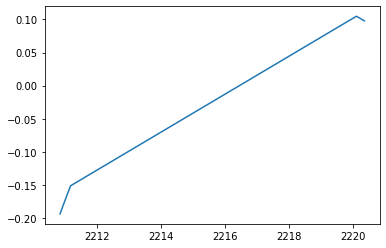

In [52]:
sns.lineplot(x=t.detach().cpu().numpy(), y=rx)

In [54]:
x.shape

torch.Size([1, 7, 2])

In [56]:
t.shape

torch.Size([7])

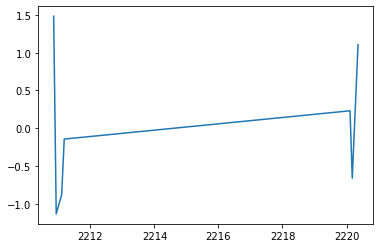

In [57]:
sns.lineplot(x=t.detach().cpu().numpy(), y=x[0,:,0])

In [ ]:
break

In [ ]:
recs = recs.squeeze()

In [ ]:
recs[ix].squeeze().shape

In [ ]:
recs[ix]

In [ ]:
# sns.lineplot(x=ts[0][:100], y=recs[ix][:100].squeeze().detach().cpu().numpy())
sns.lineplot(x=ts[0], y=recs[ix].squeeze().detach().cpu().numpy())

In [ ]:
truths.shape

In [ ]:
# sns.lineplot(x=ts[0][:100], y=truths[ix][:100].squeeze().detach().cpu().numpy())
sns.lineplot(x=ts[0], y=truths[ix].squeeze().detach().cpu().numpy())

### TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
z_us.shape

In [ ]:
latents = z_us.squeeze().detach().cpu().numpy()

In [ ]:
latents.shape

In [ ]:
tsne = TSNE(perplexity=10)

In [ ]:
xx = tsne.fit_transform(latents)

In [ ]:
sns.scatterplot(x=xx[:,0], y=xx[:,1])

In [ ]:
df = pd.DataFrame(xx, columns=['x1','x2'])
df['minimums'] = [np.round(x.min().item(),2) for x in truths]

In [ ]:
sns.scatterplot(x='x1', y='x2', data=df, hue='minimums')

In [ ]:
g=df.loc[(df['x1']<-100) & (df['x2']<-100)]
g=df.loc[(df['x1']>0) & (df['x2']>100)]

In [ ]:
gx = g.index

In [ ]:
len(truths)

In [ ]:
ls=truths[gx]

In [ ]:
for i, p in enumerate(truths):
    x = p.detach().cpu().squeeze().numpy()
    plt.figure(figsize=(5,3))
    sns.lineplot(x=ts[i], y=x)
    plt.show()